In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
from collections import deque
import torch
from torch.nn.attention import flex_attention
from torchtune.modules import attention_utils

score_mod: flex_attention._score_mod_signature | None = None
# score_mods: deque[flex_attention._score_mod_signature | None] = deque()


# We cannot do nested compile, but flex attention only has perf benefits
# when compiled. To insulate it from the compiler, we wrap it with
# compiler.disable so that it can be used regardless of whether the model
# is compiled or not, and flex attention always remains compiled.
@torch.compiler.disable(recursive=False)
def compile_friendly_flex_attention(
    q: torch.Tensor,
    k: torch.Tensor,
    v: torch.Tensor,
    block_mask: flex_attention.BlockMask,
) -> torch.Tensor:
    return attention_utils.flex_attention_compiled(
        q,
        k,
        v,
        score_mod=score_mod,
        block_mask=block_mask,
        kernel_options={
            # "BLOCK_M": 64,
            # "BLOCK_N": 64,
            # "BLOCK_M1": 64,
            # "BLOCK_N1": 64,
            "BLOCK_M2": 64,
            "BLOCK_N2": 64,
        },
    )  # type: ignore


attention_utils.compile_friendly_flex_attention = compile_friendly_flex_attention

In [4]:
import art
from art.torchtune.config import (
    ModelConfig,
    MetricLoggerConfig,
    OptimizerConfig,
    CheckpointerConfig,
    RecipeConfig,
)
from art.torchtune.recipe import FullFinetuneRecipeDistributed
import asyncio
import glob
import os

process = await asyncio.subprocess.create_subprocess_exec(
    "huggingface-cli",
    "download",
    "Qwen/Qwen3-14B",
    stdout=asyncio.subprocess.PIPE,
    stderr=asyncio.subprocess.PIPE,
)
stdout, _ = await process.communicate()
checkpoint_dir = stdout.decode("utf-8").splitlines()[-1].strip()
safetensor_files = glob.glob(f"{checkpoint_dir}/*.safetensors")
checkpoint_files = sorted(os.path.basename(f) for f in safetensor_files)
print("checkpoint_dir", checkpoint_dir)
print("checkpoint_files", checkpoint_files)

cfg = RecipeConfig(
    model=ModelConfig(_component_="torchtune.models.qwen3.qwen3_14b_instruct"),
    metric_logger=MetricLoggerConfig(
        _component_="torchtune.training.metric_logging.StdoutLogger"
    ),
    optimizer=OptimizerConfig(_component_="torch.optim.AdamW"),
    checkpointer=CheckpointerConfig(
        _component_="torchtune.training.FullModelHFCheckpointer",  # type: ignore
        model_type="QWEN3",
        checkpoint_dir=checkpoint_dir,  # type: ignore
        checkpoint_files=checkpoint_files,  # type: ignore
    ),
    output_dir=os.path.abspath("../.art/temporal-clue/models/002"),
    enable_activation_checkpointing=True,
    enable_activation_offloading=True
)

recipe = FullFinetuneRecipeDistributed(cfg=cfg)  # type: ignore
recipe.setup(cfg=cfg)

checkpoint_dir /home/ubuntu/.cache/huggingface/hub/models--Qwen--Qwen3-14B/snapshots/8268fe3026cb304910457689366670e803a6fd56
checkpoint_files ['model-00001-of-00008.safetensors', 'model-00002-of-00008.safetensors', 'model-00003-of-00008.safetensors', 'model-00004-of-00008.safetensors', 'model-00005-of-00008.safetensors', 'model-00006-of-00008.safetensors', 'model-00007-of-00008.safetensors', 'model-00008-of-00008.safetensors']


INFO:torchtune.utils._logging:Distributed training is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 4.67 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory active: 27.66 GiB
	GPU peak memory alloc: 27.66 GiB
	GPU peak memory reserved: 27.66 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.


In [5]:
micro_batches, batch = recipe._get_micro_batches(curr_epoch=0)
inputs = micro_batches[0]

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-14B")

In [7]:
print("".join(tokenizer.decode(token_id) for token_id in inputs["tokens"][0]))

<|im_start|>user
On a dark winter night, wealthy and enigmatic Mr. John Q. Boddy hosted a small, but lavish, dinner party for some of his closest associates. However, the night ended in tragedy when Mr. Boddy was found dead in one of the rooms of Tudor Mansion in the early hours of the morning. The following persons of interest have been identified as suspects:

• Mrs. Peacock
• Mrs. White
• Sgt. Gray
• Colonel Mustard
• Professor Plum
• Mr. Green
• Madame Rose
• Monsieur Brunette
• Miss Peach
• Miss Scarlet

And the following weapons were found on the premises:

• Candlestick
• Knife
• Revolver
• Horseshoe
• Rope
• Lead Pipe
• Wrench
• Poison

The murder could only have occured in one of the following rooms:

01. Trophy Room
02. Lounge
03. Studio
04. Gazebo
05. Conservatory
06. Billiard Room
07. Kitchen
08. Courtyard
09. Fountain
10. Drawing Room
11. Library
12. Ballroom

The rooms are laid out as follows:

  NN NN NN  
W 01|02|03 E
W 04|05|06 E
W 07|08|09 E
W 10|11|12 E
  SS SS SS  


In [8]:
end_index = inputs["tokens"][0].tolist().index(151645, 3190)
end_index

22470

In [9]:
for key in inputs:
    inputs[key] = inputs[key][:, :end_index]

In [10]:
dict(zip(range(-101, -1), [tokenizer.decode(token_id) for token_id in inputs["tokens"][0]][-100:]))

{-101: 'Studio',
 -100: ' (',
 -99: '0',
 -98: '3',
 -97: ')**',
 -96: ' at',
 -95: ' **',
 -94: '1',
 -93: '1',
 -92: ':',
 -91: '3',
 -90: '0',
 -89: ' PM',
 -88: '**',
 -87: ').\n',
 -86: '-',
 -85: ' So',
 -84: ',',
 -83: ' **',
 -82: 'Studio',
 -81: ' (',
 -80: '0',
 -79: '3',
 -78: ')**',
 -77: ' is',
 -76: ' the',
 -75: ' correct',
 -74: ' room',
 -73: ',',
 -72: ' assuming',
 -71: ' Colonel',
 -70: ' Must',
 -69: 'ard',
 -68: ' moved',
 -67: ' from',
 -66: ' the',
 -65: ' **',
 -64: 'G',
 -63: 'aze',
 -62: 'bo',
 -61: ' (',
 -60: '0',
 -59: '4',
 -58: ')**',
 -57: ' to',
 -56: ' the',
 -55: ' **',
 -54: 'Studio',
 -53: ' (',
 -52: '0',
 -51: '3',
 -50: ')**',
 -49: ' by',
 -48: ' **',
 -47: '1',
 -46: '1',
 -45: ':',
 -44: '0',
 -43: '0',
 -42: ' PM',
 -41: '**',
 -40: '.\n\n',
 -39: '---\n\n',
 -38: '###',
 -37: ' Final',
 -36: ' Answers',
 -35: ':\n',
 -34: 'A',
 -33: '.',
 -32: ' Miss',
 -31: ' Scarlet',
 -30: '  \n',
 -29: 'B',
 -28: '.',
 -27: ' Rev',
 -26: 'olver',
 -25: 

In [11]:
from torchtune.utils import batch_to_device

batch_to_device(inputs, device=recipe._device) # type: ignore

In [12]:
import torch
from torch.nn.attention.flex_attention import create_block_mask, BlockMask

def make_block_mask(
    group_ids: torch.Tensor,  # [B, S]  int32/64
    parent_ids: torch.Tensor,  # [B, S]  int32/64
    block_size: int = 256,  # Reduced from 128 to 64 to avoid OOM
) -> BlockMask:
    """
    FlexAttention equivalent of

        causal_mask & (group_ids[q]==group_ids[kv]  |  parent_ids[kv]==group_ids[q])

    * group_ids : id shared by all tokens of the same sampled trajectory
    * parent_ids: id identifying the prompt that produced each token
    """
    B, S = group_ids.shape  # batch, sequence length

    # the closure captures the two id tensors; that's fine for torch.compile
    def mask_mod(b, h, q_idx, kv_idx):
        # causal constraint
        causal = kv_idx <= q_idx

        same_group = group_ids[b, q_idx] == group_ids[b, kv_idx]
        prompt_link = parent_ids[b, q_idx] == group_ids[b, kv_idx]

        return causal & (same_group | prompt_link)

    return create_block_mask(
        mask_mod,
        B=B,
        H=None,
        Q_LEN=S,
        KV_LEN=S,
        BLOCK_SIZE=block_size,
    )

block_mask = make_block_mask(
    group_ids=inputs["group_ids"],
    parent_ids=inputs["parent_ids"],
)

In [13]:
def calculate_tensor_memory_gb(
    shape: tuple[int, ...],
    dtype: torch.dtype = torch.float32,
    binary_gb: bool = True,
) -> float:
    """
    Calculate the memory usage of a tensor in gigabytes without creating it.

    Args:
        shape: The shape/dimensions of the tensor (e.g., (1024, 1024, 512))
        dtype: The data type of the tensor (e.g., torch.float32, torch.float16)
        binary_gb: If True, use binary GB (1024^3), if False use decimal GB (10^9)

    Returns:
        Memory usage in gigabytes
    """
    # Calculate total number of elements
    total_elements = 1
    for dim in shape:
        total_elements *= dim

    # Get bytes per element based on dtype
    bytes_per_element = torch.tensor([], dtype=dtype).element_size()

    # Calculate total bytes
    total_bytes = total_elements * bytes_per_element

    # Convert to GB
    if binary_gb:
        gb_divisor = 1024**3  # 1 GiB = 1024^3 bytes
    else:
        gb_divisor = 10**9  # 1 GB = 10^9 bytes

    return total_bytes / gb_divisor

calculate_tensor_memory_gb((1, inputs["tokens"].shape[1], inputs["tokens"].shape[1]), dtype=torch.bfloat16)

0.9404512122273445

In [14]:
attn_bias = torch.zeros((1, inputs["tokens"].shape[1], inputs["tokens"].shape[1]), dtype=torch.bfloat16, device=recipe._device, requires_grad=True)
attn_bias

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0',
       dtype=torch.bfloat16, requires_grad=True)

In [15]:
score_mod = lambda score, b, h, q_idx, kv_idx: score + attn_bias[b, q_idx, kv_idx]

In [16]:
# score_mods_list = [score_mod if i % 2 == 0 else None for i in range(len(recipe._model.layers))]
# score_mods = deque(score_mods_list)

In [17]:
# score_mods = deque([score_mod] + [None] * (len(recipe._model.layers) - 1))
# score_mods = deque([None] * (len(recipe._model.layers) - 1) + [score_mod])

In [18]:
with recipe.activations_handling_ctx:
    hidden_states = recipe._model(
        tokens=inputs["tokens"],
        mask=block_mask,
        input_pos=inputs["input_pos"],
    )

del block_mask

DEBUG:torchtune.utils._logging:Using flex attention for attention computation since a BlockMask was passed in.


In [19]:
from art.unsloth.train import shift_tensor
from typing import cast

assistant_mask = shift_tensor(inputs["assistant_mask"], False)
hidden_states = hidden_states[assistant_mask]
next_token_ids = shift_tensor(inputs["tokens"], 0)[assistant_mask]
chunk_size = batch.dev_config.get("logprob_calculation_chunk_size", 1024)
loss = torch.tensor(0.0, device=recipe._device)
all_new_logprobs = []
for i in range(0, hidden_states.size(0), chunk_size):
    chunk_end = min(i + chunk_size, hidden_states.size(0))
    # [chunk_size, hidden_size] @ [hidden_size, vocab_size]
    logits = cast(
        torch.Tensor, recipe._model.output(hidden_states[i:chunk_end,:])
    )  # [chunk_size, vocab_size]
    selected_logits = torch.gather(
        logits, dim=-1, index=next_token_ids[i:chunk_end].unsqueeze(-1)
    ).squeeze(
        -1
    )  # [chunk_size]
    logsumexp = torch.logsumexp(logits, dim=-1)  # [chunk_size]
    new_logprobs = selected_logits - logsumexp
    all_new_logprobs.append(new_logprobs)
    # loss += new_logprobs.sum()
    loss += logits.sum()
    # loss += torch.exp(new_logprobs).sum()
    del logits, selected_logits, logsumexp, new_logprobs

new_logprobs = torch.cat(all_new_logprobs, dim=0)
new_logprobs.shape

INFO 07-21 23:37:28 [__init__.py:244] Automatically detected platform cuda.


torch.Size([19276])

In [ ]:
# # add L1 loss for attn_bias
# loss += torch.abs(attn_bias).sum() * 10

In [ ]:
# import gc
# import torch

# for _ in range(3):
#     gc.collect()
#     torch.cuda.empty_cache()

In [ ]:
# score_mods = deque([None] * (len(recipe._model.layers) - 1) + [score_mod])
# score_mods = deque(reversed(score_mods_list))
result = torch.autograd.grad(loss, attn_bias)

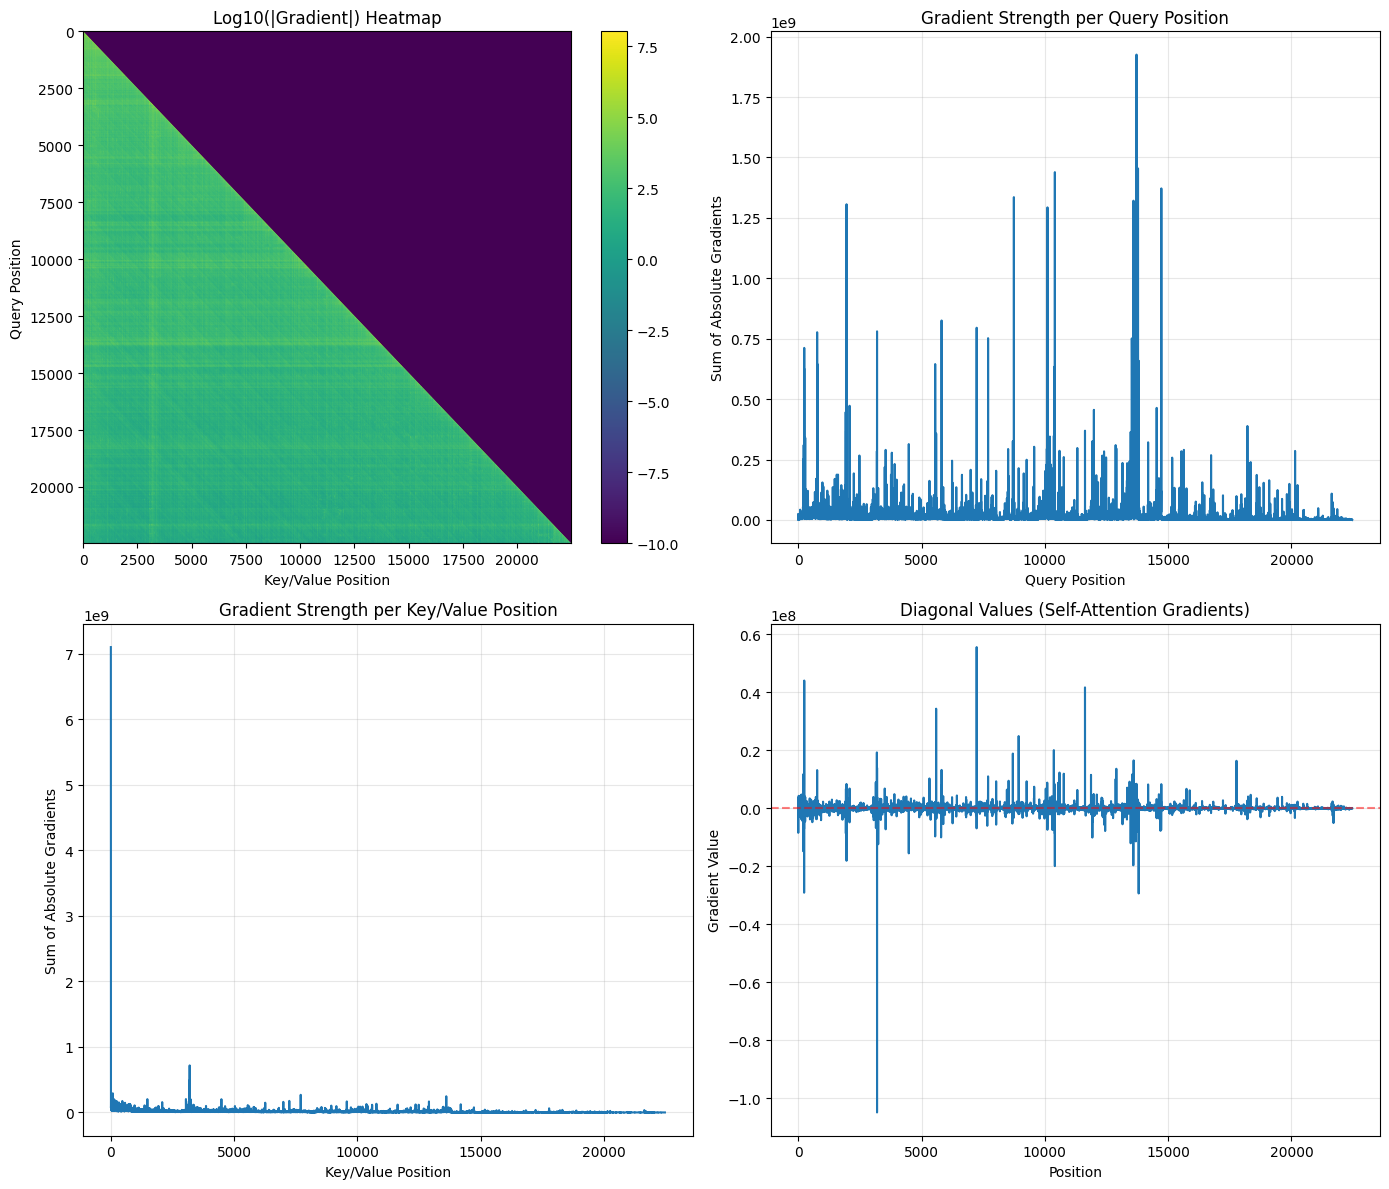

Pattern Analysis:
- Strongest gradient at position: ((np.int64(3196), np.int64(3196)))
- Diagonal mean: 26495.906250
- Off-diagonal mean: -1.180599
- Upper triangular sum: 0.000000
- Lower triangular sum: -596061824.000000


In [24]:
# Analyze attention patterns
import matplotlib.pyplot as plt
import numpy as np

grad_matrix = result[0][0].detach().cpu().float().numpy()

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Full heatmap with log scale
ax = axes[0, 0]
im = ax.imshow(np.log10(np.abs(grad_matrix) + 1e-10), cmap='viridis', aspect='auto')
ax.set_title('Log10(|Gradient|) Heatmap')
ax.set_xlabel('Key/Value Position')
ax.set_ylabel('Query Position')
plt.colorbar(im, ax=ax)

# 2. Row-wise sum (gradient strength per query position)
ax = axes[0, 1]
row_sums = np.abs(grad_matrix).sum(axis=1)
ax.plot(row_sums)
ax.set_title('Gradient Strength per Query Position')
ax.set_xlabel('Query Position')
ax.set_ylabel('Sum of Absolute Gradients')
ax.grid(True, alpha=0.3)

# 3. Column-wise sum (gradient strength per key/value position)
ax = axes[1, 0]
col_sums = np.abs(grad_matrix).sum(axis=0)
ax.plot(col_sums)
ax.set_title('Gradient Strength per Key/Value Position')
ax.set_xlabel('Key/Value Position')
ax.set_ylabel('Sum of Absolute Gradients')
ax.grid(True, alpha=0.3)

# 4. Diagonal values (self-attention gradients)
ax = axes[1, 1]
diagonal = np.diag(grad_matrix)
ax.plot(diagonal)
ax.set_title('Diagonal Values (Self-Attention Gradients)')
ax.set_xlabel('Position')
ax.set_ylabel('Gradient Value')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print pattern analysis
print("Pattern Analysis:")
print(f"- Strongest gradient at position: ({np.unravel_index(np.argmax(np.abs(grad_matrix)), grad_matrix.shape)})")
print(f"- Diagonal mean: {diagonal.mean():.6f}")
print(f"- Off-diagonal mean: {(grad_matrix.sum() - diagonal.sum()) / (grad_matrix.size - len(diagonal)):.6f}")
print(f"- Upper triangular sum: {np.triu(grad_matrix, k=1).sum():.6f}")
print(f"- Lower triangular sum: {np.tril(grad_matrix, k=-1).sum():.6f}")


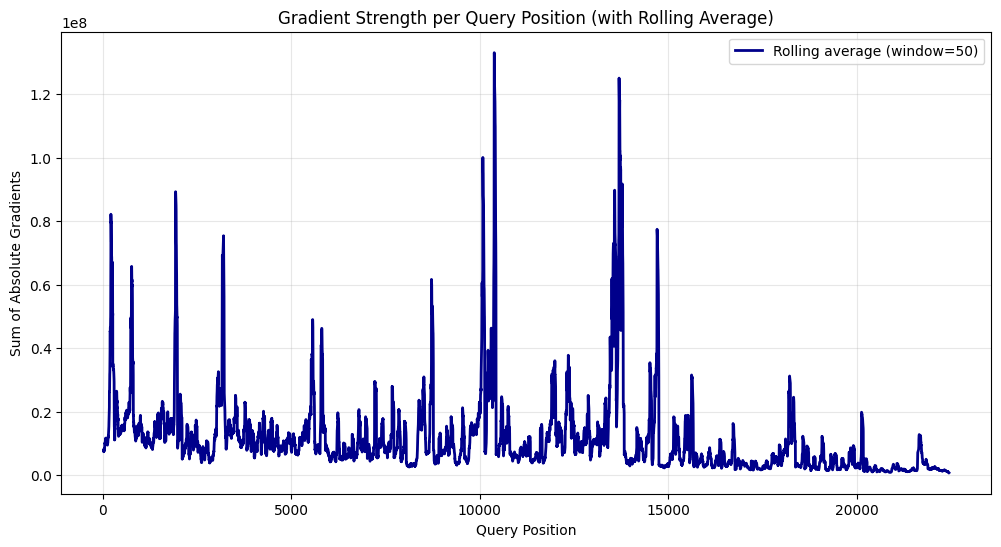

In [60]:
# Plot gradient strength per query position with rolling average
row_sums = np.abs(grad_matrix).sum(axis=1)

# Calculate rolling average (window size of 50)
window_size = 50
rolling_avg = np.convolve(row_sums, np.ones(window_size)/window_size, mode='valid')

# Create x-axis for rolling average that matches its length
rolling_x = range(window_size//2, window_size//2 + len(rolling_avg))

plt.figure(figsize=(12, 6))
# plt.plot(row_sums, alpha=0.3, label='Raw gradient strength', color='lightblue')
plt.plot(rolling_x, rolling_avg, 
         label=f'Rolling average (window={window_size})', color='darkblue', linewidth=2)
plt.title('Gradient Strength per Query Position (with Rolling Average)')
plt.xlabel('Query Position')
plt.ylabel('Sum of Absolute Gradients')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [57]:
result[0][0][-2].to(torch.float32).tolist()

[-17792.0,
 288.0,
 1104.0,
 -768.0,
 33.0,
 100.0,
 105.0,
 103.5,
 6.375,
 -11.8125,
 -56.0,
 16.125,
 78.5,
 57.5,
 -130.0,
 50.5,
 2.796875,
 -5.15625,
 -129.0,
 64.5,
 -2.421875,
 -6.78125,
 58.75,
 -15.3125,
 -9.0625,
 -16.0,
 -17.375,
 55.75,
 110.5,
 -40.5,
 29.625,
 -10.6875,
 -1.984375,
 28.125,
 70.0,
 -63.0,
 56.0,
 3.3125,
 -15.4375,
 31.625,
 -15.0,
 13.25,
 42.5,
 54.75,
 83.0,
 12.25,
 -2.140625,
 43.5,
 46.0,
 22.0,
 13.8125,
 11.75,
 0.953125,
 -8.4375,
 -59.75,
 69.5,
 30.625,
 580.0,
 230.0,
 108.5,
 -11.9375,
 -53.0,
 4.9375,
 29.5,
 4.71875,
 2.5625,
 25.0,
 34.5,
 -10.1875,
 6.59375,
 53.0,
 -2.328125,
 169.0,
 -6.875,
 1.515625,
 115.0,
 5.09375,
 149.0,
 99.5,
 260.0,
 72.0,
 -54.25,
 36.25,
 28.125,
 169.0,
 -51.75,
 129.0,
 -10.125,
 520.0,
 29.25,
 -57.75,
 464.0,
 -75.5,
 50.75,
 -306.0,
 -59.0,
 -247.0,
 -414.0,
 -19.0,
 2.515625,
 -45.75,
 -164.0,
 80.0,
 -50.75,
 -89.5,
 22.0,
 -15.4375,
 69.0,
 -20.375,
 -32.5,
 444.0,
 1344.0,
 -129.0,
 -32.75,
 69.0,


In [56]:
from illustrate import illustrate

# -44: Professor Plum
# -39: Revolver
# -34: Gazebo
# -18: Ambition
# -13: Betrayal
# -7: Conservatory
# -2: Lounge

print(
    illustrate(
        list(
            zip(
                list(tokenizer.decode(token_id) for token_id in inputs["tokens"][0]),
                result[0][0][-7].to(torch.float32).tolist(),
                # result[0][0].sum(dim=1).squeeze(0).tolist(),
            )
        ),
        gradient="one-dark-simple",
    )
)

╔═════════════════════════════════════════════════════════════╗
║ Stats: scale=16384.000, min=-12096.000, max=16384.000, mean=-0.005 ║
╚═════════════════════════════════════════════════════════════╝

<|im_start|>user
On a dark winter night, wealthy and enigmatic Mr. John Q. Boddy hosted a small, but lavish, dinner party for some of his closest associates. However, the night ended in tragedy when Mr. Boddy was found dead in one of the rooms of Tudor Mansion in the early hours of the morning. The following persons of interest have been identified as suspects:

• Mrs. Peacock
• Mrs. White
• Sgt. Gray
• Colonel Mustard
• Professor Plum
• Mr. Green
• Madame Rose
• Monsieur Brunette
• Miss Peach
• Miss Scarlet

And the following weapons were found on the premises:

• Candlestick
• Knife
• Revolver
• Horseshoe
• Rope
• Lead Pipe
• Wrench
• Poison

The murder could only have occured in one of the following rooms:

01. Trophy Room
02. Lounge
03. Studio
04. Gazebo
05. Conservatory
06. Billiard R

In [26]:
grads = result[0]
grads

tensor([[[ 9.5000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 3.3751e+06, -3.3423e+06,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.0486e+07, -2.0070e+06, -8.4541e+06,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 9.1520e+03, -2.6719e+00,  3.8800e+02,  ..., -8.7040e+03,
           0.0000e+00,  0.0000e+00],
         [-1.7792e+04,  2.8800e+02,  1.1040e+03,  ...,  4.3520e+03,
           2.3840e+03,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]], device='cuda:0', dtype=torch.bfloat16)

In [55]:
grads[0][-7]

tensor([4384.,  -26.,  124.,  ...,    0.,    0.,    0.], device='cuda:0',
       dtype=torch.bfloat16)

tensor(0., device='cuda:0', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)

In [ ]:
from illustrate import illustrate

tokens = [tokenizer.decode(token_id) for token_id in inputs["tokens"][0]]
logprobs = torch.exp(new_logprobs).tolist()
print(
    illustrate(
        list(
            zip(
                tokens,
                [0] * (len(tokens) - len(logprobs)) + logprobs,
            )
        ),
        gradient="one-dark-simple",
    )
)

In [ ]:
new_logprobs

In [ ]:
([0] * (len(tokens) - len(logprobs)) + logprobs)[-3]

In [ ]:
result[0].sum(dim=1).squeeze(0).tolist()

In [ ]:
[tokenizer.decode(token_id) for token_id in inputs["tokens"][0]][-100:]

In [ ]:
loss.backward()

In [ ]:
recipe._optimizer.step()
recipe._optimizer.zero_grad()

In [ ]:
hidden_states.shape

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-14B")

In [ ]:
recipe._model.layers